Lineares Regressionsmodell: Einfluss von Infrastruktur & Bars auf Unfallhäufigkeit (Acc_EN)

Ziel
Vorhersage und Erklärung der Unfallhäufigkeit pro Grid (**Acc_EN**) anhand von infrastrukturellen Merkmalen
(z. B. Straßenlänge, Fahrspuren, Einbahnstraßen, Ampeln) sowie der Anzahl Bars (**bar_count**).

Vorgehen
- Train/Test-Split (80/20), Seed = 42
- Standardisierung aller Features zur Vergleichbarkeit der Koeffizienten
- Modell: Lineare Regression (sklearn)
- Bewertung: R², MAE, RMSE
- Feature-Interpretation: standardisierte Koeffizienten, Permutation Importance und Bootstrap-95%-Konfidenzintervalle

Import der wichtigsten Bibliotheken

In [3]:
import numpy as np
import scipy
import sklearn
import pandas as pd
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

Train/Test-Split (80/20) und Standardisierung aller Features zur Vergleichbarkeit der Effekte.
Lineares Regressionsmodell zur Erklärung der Unfallanzahl pro Grid (Acc_EN).

In [4]:
# Laden
grid_clean = gpd.read_parquet("grid_features.parquet")

model_features = [
    'bar_count', 'road_km', 'segments_count', 'segments_per_roadkm',
    'dist_center', 'major_road_km_share', 'residential_km_share',
    'maxspeed_mean_weighted', 'maxspeed_share_over50',
    'lanes_mean_weighted', 'lanes_share_ge2',
    'signals_per_roadkm', 'crossings_per_roadkm',
    'oneway_km_share', 'sidewalk_km_share', 'parking_km_share'
]
target = "Acc_EN"

# Daten
X = grid_clean[model_features].copy()
y = grid_clean[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardisieren
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_s, y_train)

# Performance
pred = lr.predict(X_test_s)
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print("Linear Regression (Test)")
print(f"R²={r2:.3f} | MAE={mae:.3f} | RMSE={rmse:.3f}")

# Koeffizienten (vergleichbar, weil standardisiert)
coef_df = pd.DataFrame({
    "Feature": model_features,
    "Coef_(std)": lr.coef_
}).sort_values("Coef_(std)", key=np.abs, ascending=False)

print("\nKoeffizienten (sortiert nach |coef|)")
print(coef_df.to_string(index=False))

# Permutation Importance (R² drop auf Test)
perm = permutation_importance(
    lr, X_test_s, y_test,
    scoring="r2",
    n_repeats=30,
    random_state=42
)

perm_df = pd.DataFrame({
    "Feature": model_features,
    "PermImp_mean(R2_drop)": perm.importances_mean,
    "PermImp_std": perm.importances_std
}).sort_values("PermImp_mean(R2_drop)", ascending=False)

print("\nPermutation Importance (R² drop, höher = wichtiger)")
print(perm_df.to_string(index=False))

# Bootstrap 95%-CI für "Signifikanz"
N_BOOT = 300
rng = np.random.default_rng(42)

boot = np.zeros((N_BOOT, len(model_features)))
n = X_train_s.shape[0]

for b in range(N_BOOT):
    idx = rng.integers(0, n, size=n)
    lr_b = LinearRegression()
    lr_b.fit(X_train_s[idx], y_train.iloc[idx])
    boot[b] = lr_b.coef_

ci_low  = np.percentile(boot, 2.5, axis=0)
ci_high = np.percentile(boot, 97.5, axis=0)

boot_df = pd.DataFrame({
    "Feature": model_features,
    "Coef_(std)": lr.coef_,
    "CI_2.5%": ci_low,
    "CI_97.5%": ci_high
})
boot_df["Significant_95%"] = ~((boot_df["CI_2.5%"] <= 0) & (boot_df["CI_97.5%"] >= 0))
boot_df = boot_df.sort_values(["Significant_95%"], ascending=False)\
                 .sort_values("Coef_(std)", key=np.abs, ascending=False)

print("\n Bootstrap 95% CI (Significant_95%=True => 0 nicht im CI)")
print(boot_df.to_string(index=False))

print("\nSignifikante Features (Bootstrap 95%)")
sig = boot_df[boot_df["Significant_95%"]]
if len(sig) == 0:
    print("Keine signifikanten Features nach Bootstrap-95%-CI.")
else:
    print(sig[["Feature","Coef_(std)","CI_2.5%","CI_97.5%"]].to_string(index=False))

Linear Regression (Test)
R²=0.546 | MAE=1.788 | RMSE=3.088

Koeffizienten (sortiert nach |coef|)
               Feature  Coef_(std)
             bar_count    3.123084
       oneway_km_share    0.900278
               road_km    0.758978
        segments_count    0.752917
maxspeed_mean_weighted   -0.749629
    signals_per_roadkm    0.644665
           dist_center   -0.573970
       lanes_share_ge2    0.533422
  residential_km_share   -0.390286
   major_road_km_share    0.225558
   lanes_mean_weighted   -0.178291
  crossings_per_roadkm    0.147445
 maxspeed_share_over50   -0.145210
     sidewalk_km_share   -0.082579
   segments_per_roadkm   -0.067929
      parking_km_share    0.011138

Permutation Importance (R² drop, höher = wichtiger)
               Feature  PermImp_mean(R2_drop)  PermImp_std
             bar_count               0.474746     0.050008
       oneway_km_share               0.081996     0.018239
maxspeed_mean_weighted               0.059361     0.014261
        segments_co

Modellbewertung: Visualisierung der Testmetriken

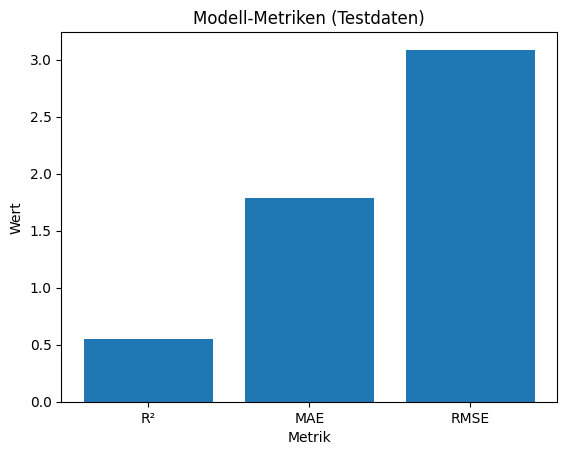

In [ ]:
import matplotlib.pyplot as plt

metrics = {
    "R²": r2,
    "MAE": mae,
    "RMSE": rmse
}

names = list(metrics.keys())
values = list(metrics.values())

plt.figure()
plt.bar(names, values)
plt.title("Modell-Metriken (Testdaten)")
plt.ylabel("Wert")
plt.xlabel("Metrik")
plt.show()


Signifikante Features (Bootstrap 95 %-CI)

Visualisierung der signifikanten standardisierten Koeffizienten mit Konfidenzintervallen.
Fehlerbalken zeigen die Unsicherheit der geschätzten Effekte.

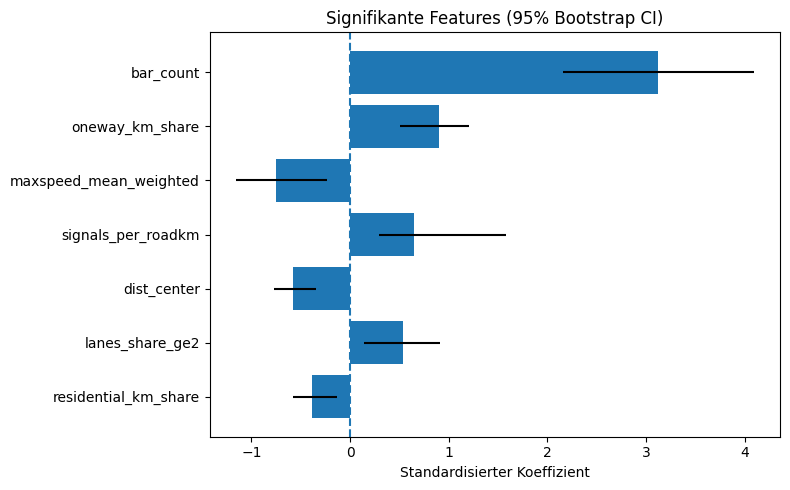

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Nur signifikante Features auswählen
sig_df = boot_df[boot_df["Significant_95%"]].copy()

# Sortieren nach Betrag des Koeffizienten
sig_df = sig_df.sort_values("Coef_(std)", key=np.abs)

features = sig_df["Feature"]
coef = sig_df["Coef_(std)"]
err_low = coef - sig_df["CI_2.5%"]
err_high = sig_df["CI_97.5%"] - coef
errors = [err_low, err_high]

plt.figure(figsize=(8, 5))
plt.barh(features, coef, xerr=errors)
plt.axvline(0, linestyle="--")   # Null-Linie
plt.xlabel("Standardisierter Koeffizient")
plt.title("Signifikante Features (95% Bootstrap CI)")
plt.tight_layout()
plt.show()


Lineare Regression: Feature-Koeffizienten

Darstellung der standardisierten Modell-Koeffizienten zur Bewertung von Richtung und Stärke der Feature-Effekte

In [ ]:
lin_model = lr

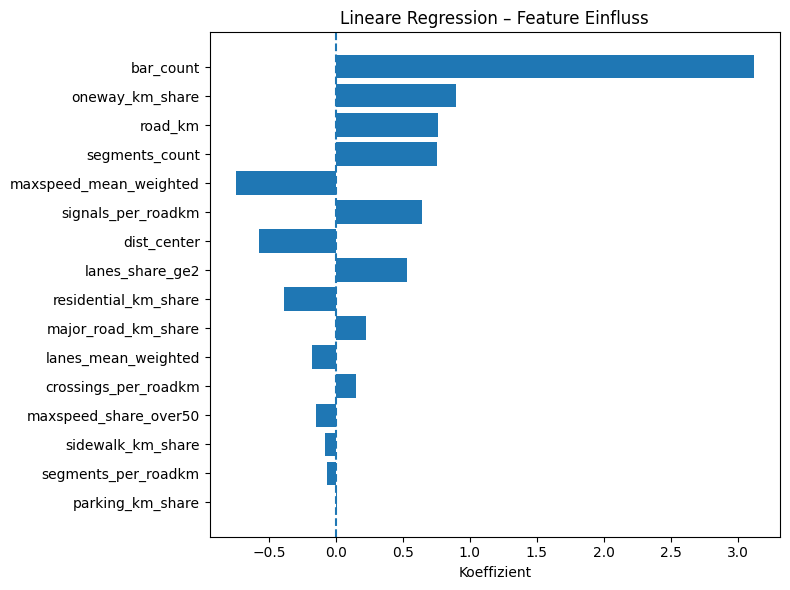

In [ ]:
# Tabelle aus Modell bauen
coef_df = pd.DataFrame({
    "Feature": model_features,
    "Coefficient": lin_model.coef_
}).sort_values("Coefficient", key=np.abs)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(coef_df["Feature"], coef_df["Coefficient"])
plt.axvline(0, linestyle="--")
plt.xlabel("Koeffizient")
plt.title("Lineare Regression – Feature Einfluss")
plt.tight_layout()
plt.show()


Lineare Regression: Koeffizienten und Signifikanz (Bootstrap 95 %-CI).

Visualisierung aller standardisierten Koeffizienten mit Konfidenzintervallen.
Rot = signifikant, Grau = nicht signifikant.

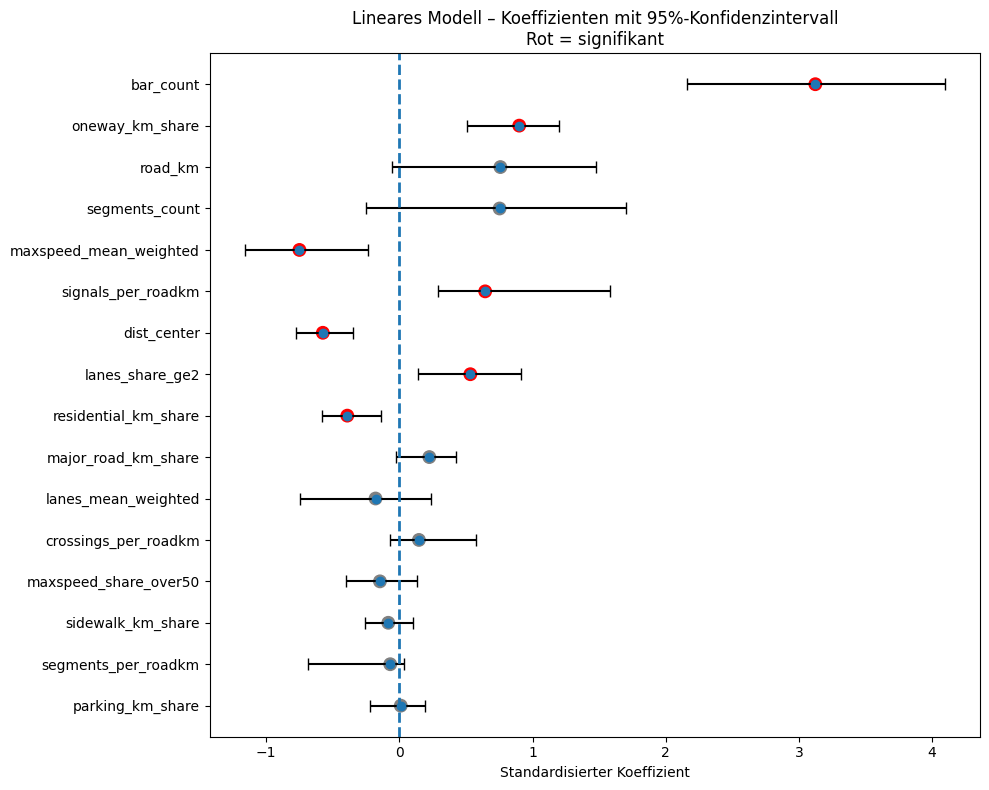

In [ ]:
# Sortieren nach Effektstärke
plot_df = boot_df.sort_values("Coef_(std)", key=np.abs, ascending=True)

y_pos = np.arange(len(plot_df))

plt.figure(figsize=(10, 8))

# Fehlerbalken = Konfidenzintervalle
plt.errorbar(
    plot_df["Coef_(std)"],
    y_pos,
    xerr=[
        plot_df["Coef_(std)"] - plot_df["CI_2.5%"],
        plot_df["CI_97.5%"] - plot_df["Coef_(std)"]
    ],
    fmt="o",
    ecolor="black",
    capsize=4
)

# Punkte einfärben nach Signifikanz
colors = plot_df["Significant_95%"].map({True: "red", False: "gray"})
plt.scatter(plot_df["Coef_(std)"], y_pos, c=colors, s=80)

# Nulllinie (keine Wirkung)
plt.axvline(0, linestyle="--", linewidth=2)

plt.yticks(y_pos, plot_df["Feature"])
plt.xlabel("Standardisierter Koeffizient")
plt.title("Lineares Modell – Koeffizienten mit 95%-Konfidenzintervall\nRot = signifikant")

plt.tight_layout()
plt.show()
